In [ ]:
# standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
# statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
# os
import os
import sys
# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# tf
import tensorflow as tf
# keras
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Layer, LSTM, GRU, SimpleRNN, Dense, Activation, Bidirectional, Dropout
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras import optimizers
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.regularizers import l1,l2

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Import btc
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Path
path = '/content/gdrive/MyDrive/Colab Notebooks/NN Time Series Project/data'
sys.path.append(path)

In [ ]:
# Import atRNN
from atrnn import AlphatRNN

In [ ]:
# Make pd df
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/NN Time Series Project/data/btc.csv')

In [ ]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Drop extraneous columns
df.drop(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)'], axis = 1, inplace = True)
# Drop bottom 3m rows and top 800k
df.drop(df.index[:3000000], axis = 0, inplace = True)
df.drop(df.index[4000000:], axis = 0, inplace = True)
# Reset index; drop column
df.reset_index(drop = True, inplace = True)
# Backfill na's
df.fillna(method = 'backfill', inplace = True)

In [ ]:
# RNN target/features
features = ['Weighted_Price']
target = 'Weighted_Price'

In [ ]:
# Split train sets
train_weight = 0.8
df_split = int( len(df) * train_weight )

train = df.iloc[:df_split]
test = df.iloc[df_split:]

In [ ]:
# Scaling parameters
mu = float( train[features].mean() )
sigma = float( train[features].std() )

# Scale data
train = train[features].apply( lambda x: (x - mu) / sigma )
test = test[features].apply( lambda x: (x - mu) / sigma )

In [ ]:
'''
Function for reshaping data into one-step ahead time series prediction format
    value: feature value to be lagged
    n_steps: number of steps/sequence length
    n_steps_ahead: forecasting horizon
'''

def get_lagged_features(value, n_steps, n_steps_ahead):
    lag_list = []
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append( value.shift(lag) )
    return pd.concat(lag_list, axis = 1)

In [ ]:
# Number of steps ahead
n_steps_ahead = n_steps = 5

# Transform training input and output data
col_ords = []
for i in range(n_steps):
    for j in range(len(features)):
        col_ords.append(i + j * n_steps)

x_train_list = []
for f in features:
    x_train_reg = get_lagged_features(train, n_steps, n_steps).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis = 1)
        
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape( x_train_reg.values, ( x_train_reg.shape[0], int( x_train_reg.shape[1] / len(features)), len(features) ) )
y_train_reg = np.reshape( y_train_reg, (y_train_reg.shape[0], 1, 1))

In [ ]:
# Transform test input and output data
x_test_list = []
for f in features:
    x_test_reg = get_lagged_features(test, n_steps, n_steps).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis = 1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape( x_test_reg.values, ( x_test_reg.shape[0], int( x_test_reg.shape[1] / len(features)), len(features) ) )
y_test_reg = np.reshape( y_test_reg, (y_test_reg.shape[0], 1, 1))

In [ ]:
# Verify tensor shapes
#   value 1: # of observations
#   value 2: sequence length, or number of lags
#   value 3: dimension of each element in the sequence (x) or output vector (y): this is univariate time analysis, so the dimension of I/O is 1

print(x_train_reg.shape)
print(y_train_reg.shape)
print(x_test_reg.shape)
print(y_test_reg.shape)

(1485892, 5, 1)
(1485892, 1, 1)
(371467, 5, 1)
(371467, 1, 1)


In [ ]:
# Append lagged lists to train data
x_train_reg = pd.concat(x_train_list, axis = 1)
# Reshape
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape( x_train_reg.values, ( x_train_reg.shape[0], int(x_train_reg.shape[1] / len(features)), len(features) ) )

In [ ]:
# Append lagged lists to test data
x_test_reg = pd.concat(x_test_list, axis = 1)
# Reshape
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape( x_test_reg.values, ( x_test_reg.shape[0], int(x_test_reg.shape[1] / len(features)), len(features) ) )

In [ ]:
# Custom activation function
def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish)})

In [ ]:
# NN structures - SWISH
def _RNN(data = x_train_reg, n_units = 10, l1_reg = 0.0001, seed = 0, optim = 'adam', dropout = 0):
    model = Sequential()
    model.add( 
        SimpleRNN(n_units,
                  activation = 'swish', 
                  kernel_initializer = keras.initializers.glorot_uniform(seed), 
                  bias_initializer = keras.initializers.glorot_uniform(seed), 
                  recurrent_initializer = keras.initializers.orthogonal(seed), 
                  kernel_regularizer = l1(l1_reg), 
                  input_shape = (x_train_reg.shape[1], x_train_reg.shape[-1]),
                  unroll = True,
                  stateful = False) )  
    model.add(
        Dense(1, 
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg) ) )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

def _atRNN(data = x_train_reg, n_units = 10, l1_reg = 0.0001, seed = 0, optim = 'adam', dropout = 0):
    model = Sequential()
    model.add( 
        AlphatRNN(n_units,
                  activation = 'swish', 
                  recurrent_activation = 'sigmoid',
                  kernel_initializer = keras.initializers.glorot_uniform(seed), 
                  bias_initializer = keras.initializers.glorot_uniform(seed), 
                  recurrent_initializer = keras.initializers.orthogonal(seed), 
                  kernel_regularizer = l1(l1_reg), 
                  input_shape = (x_train_reg.shape[1], x_train_reg.shape[-1]),
                  unroll = True,
                  stateful = False) )  
    model.add(
        Dense(1, 
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg) ) )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

In [ ]:
# Hyperparameters
n_epoches = 50
batch_size = 1000

In [ ]:
# Implement early stopping monitor to speed up cross validation
es = EarlyStopping(monitor = 'loss', mode = 'min', verbose = 1, patience = 100, min_delta = 1e-7, restore_best_weights = True)

In [ ]:
# NN models
params = {
    'srnn': {'model':'', 'function':_RNN, 'l1_reg':0.0, 'H':10, 'label':'sRNN', 'history':'', 'cv_results':''},
    'atrnn': {'model':'', 'function':_atRNN, 'l1_reg':0.0, 'H':10, 'label':'atRNN', 'history':'', 'cv_results':''}
}

In [ ]:
# Cross-validation parameters
n_units = [8, 10, 12]
l1_reg = [0.00001, 0.00005, 0.0001, 0.001]
time_series_cv = TimeSeriesSplit(n_splits = 5)
param_grid = {
    'n_units': n_units,
    'l1_reg': l1_reg
}

In [ ]:
# Cross-validate NN models
for k in params.keys():
    model = KerasRegressor(build_fn = params[k]['function'], epochs = n_epoches,
                           batch_size = batch_size, verbose = 2)
    grid = GridSearchCV(estimator = model, param_grid = param_grid,
                        cv = time_series_cv, n_jobs = 1, verbose = 2)
    grid_result = grid.fit(x_train_reg[:30000], y_train_reg[:30000], callbacks = [es])

    print("Best score: [ %f ] using param [ %s ]" % (grid_result.best_score_, grid_result.best_params_) )

    mean_scores = grid_result.cv_results_['mean_test_score']
    std_scores = grid_result.cv_results_['std_test_score']
    param_results = grid_result.cv_results_['params']

    for mean, stdev, p in zip(mean_scores, std_scores, param_results):
        print("Mean of  [ %f ] , stdev of [ %f ] using [ %s ]" % (mean, stdev, p) )

    params[k]['cv_results'] = grid_result.cv_results_
    params[k]['H'] = grid_result.best_params_['n_units']
    params[k]['l1_reg'] = grid_result.best_params_['l1_reg']

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Streaming output truncated to the last 5000 lines.
15/15 - 0s - loss: 3.1275 - 40ms/epoch - 3ms/step
Epoch 7/50
15/15 - 0s - loss: 1.6014 - 40ms/epoch - 3ms/step
Epoch 8/50
15/15 - 0s - loss: 0.3793 - 35ms/epoch - 2ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0150 - 32ms/epoch - 2ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0170 - 31ms/epoch - 2ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0016 - 32ms/epoch - 2ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0016 - 31ms/epoch - 2ms/step
Epoch 13/50
15/15 - 0s - loss: 9.6532e-04 - 32ms/epoch - 2ms/step
Epoch 14/50
15/15 - 0s - loss: 9.4801e-04 - 33ms/epoch - 2ms/step
Epoch 15/50
15/15 - 0s - loss: 9.1183e-04 - 32ms/epoch - 2ms/step
Epoch 16/50
15/15 - 0s - loss: 9.0369e-04 - 35ms/epoch - 2ms/step
Epoch 17/50
15/15 - 0s - loss: 8.9488e-04 - 33ms/epoch - 2ms/step
Epoch 18/50
15/15 - 0s - loss: 8.8712e-04 - 34ms/epoch - 2ms/step
Epoch 19/50
15/15 - 0s - loss: 8.7927e-04 - 33ms/epoch - 2ms/step
Epoch 20/50
15/15 - 0s - loss: 8.7121e-04 - 33ms/epoch - 2ms/step
Ep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Streaming output truncated to the last 5000 lines.
20/20 - 1s - loss: 5.7713 - 858ms/epoch - 43ms/step
Epoch 2/50
20/20 - 0s - loss: 5.1679 - 59ms/epoch - 3ms/step
Epoch 3/50
20/20 - 0s - loss: 4.5724 - 53ms/epoch - 3ms/step
Epoch 4/50
20/20 - 0s - loss: 3.9490 - 58ms/epoch - 3ms/step
Epoch 5/50
20/20 - 0s - loss: 3.2607 - 53ms/epoch - 3ms/step
Epoch 6/50
20/20 - 0s - loss: 2.4730 - 54ms/epoch - 3ms/step
Epoch 7/50
20/20 - 0s - loss: 1.5803 - 53ms/epoch - 3ms/step
Epoch 8/50
20/20 - 0s - loss: 0.6838 - 58ms/epoch - 3ms/step
Epoch 9/50
20/20 - 0s - loss: 0.1035 - 53ms/epoch - 3ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0040 - 53ms/epoch - 3ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0019 - 56ms/epoch - 3ms/step
Epoch 12/50
20/20 - 0s - loss: 7.2354e-04 - 57ms/epoch - 3ms/step
Epoch 13/50
20/20 - 0s - loss: 6.2924e-04 - 58ms/epoch - 3ms/step
Epoch 14/50
20/20 - 0s - loss: 6.1679e-04 - 56ms/epoch - 3ms/step
Epoch 15/50
20/20 - 0s - loss: 6.1141e-04 - 55ms/epoch - 3ms/step
Epoch 16/50
20/20 - 0

In [ ]:
print("Optimal Model Parameters Derived from 5-fold Cross-Validation:")

for k in params.keys():
    print("   Model: %s, n_units: %f, learning rate: %f" % (params[k]['label'], params[k]['H'], params[k]['l1_reg']) )

Optimal Model Parameters Derived from 5-fold Cross-Validation:
   Model: sRNN, n_units: 10.000000, learning rate: 0.000010
   Model: atRNN, n_units: 8.000000, learning rate: 0.000100


In [ ]:
# Train cross-validated NN model
for k in params.keys():
    tf.random.set_seed(0)
    model = params[k]['function'](data = x_train_reg, n_units = params[k]['H'], l1_reg = params[k]['l1_reg'] )
    params[k]['history'] = model.fit(x_train_reg, y_train_reg, epochs = n_epoches, 
                                     batch_size = batch_size, callbacks = [es], shuffle = False )
    params[k]['model'] = model

Epoch 1/50
1486/1486 [==============================] - 5s 3ms/step - loss: 0.2198
Epoch 2/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0026
Epoch 3/50
1486/1486 [==============================] - 4s 3ms/step - loss: 4.8161e-04
Epoch 4/50
1486/1486 [==============================] - 4s 3ms/step - loss: 3.2846e-04
Epoch 5/50
1486/1486 [==============================] - 4s 3ms/step - loss: 2.2000e-04
Epoch 6/50
1486/1486 [==============================] - 4s 3ms/step - loss: 2.4357e-04
Epoch 7/50
1486/1486 [==============================] - 4s 3ms/step - loss: 2.3353e-04
Epoch 8/50
1486/1486 [==============================] - 4s 3ms/step - loss: 2.3403e-04
Epoch 9/50
1486/1486 [==============================] - 4s 3ms/step - loss: 2.3273e-04
Epoch 10/50
1486/1486 [==============================] - 4s 3ms/step - loss: 2.3875e-04
Epoch 11/50
1486/1486 [==============================] - 4s 3ms/step - loss: 2.3743e-04
Epoch 12/50
1486/1486 [==========================

In [ ]:
# Store step lag for ease of indexing
step_lag = n_steps + n_steps_ahead - 1

In [ ]:
# Prediction on test and train data with NN models
for k in params.keys():
    model = params[k]['model']
    model.summary()

    params[k]['MSE_train'] = mean_squared_error(train[features][step_lag:], model.predict(x_train_reg, verbose = 1))
    params[k]['predict'] = model.predict(x_test_reg, verbose = 1)
    params[k]['MSE_test'] = mean_squared_error(test[features][step_lag:], params[k]['predict'])

Model: "sequential_333"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_183 (SimpleRNN)  (None, 10)                120       
                                                                 
 dense_332 (Dense)           (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
11609/11609 [==============================] - 15s 1ms/step
Model: "sequential_334"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 alphat_rnn_149 (AlphatRNN)  (None, 8)                 176       
                                                                 
 dense_333 (Dense)           (None, 1)                 9         
                                    

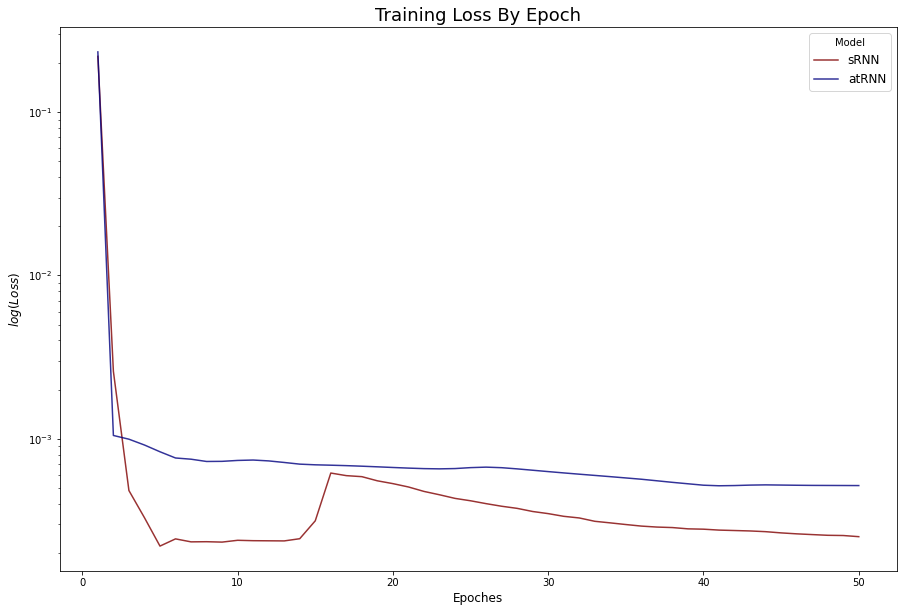

In [ ]:
# Plot training loss by epoch
fig = plt.figure(figsize = (15, 10))
epoch_arr = np.arange(1, n_epoches + 1)
colors = pl.cm.jet(np.linspace(1, 0, 2))
i = 0

for k in params.keys():
    plt.plot(epoch_arr, params[k]['history'].history['loss'], color = colors[i], label = params[k]['label'], alpha = 0.8)
    i += 1
    
plt.yscale('log')
plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Epoches', fontsize = 12)
plt.ylabel('$log(Loss)$', fontsize = 12)
plt.title('Training Loss By Epoch', fontsize = 18)

plt.show()

Text(0.5, 1.0, 'Near-term Forecasting Residual ($\\hat{Y_i} - Y_i$)')

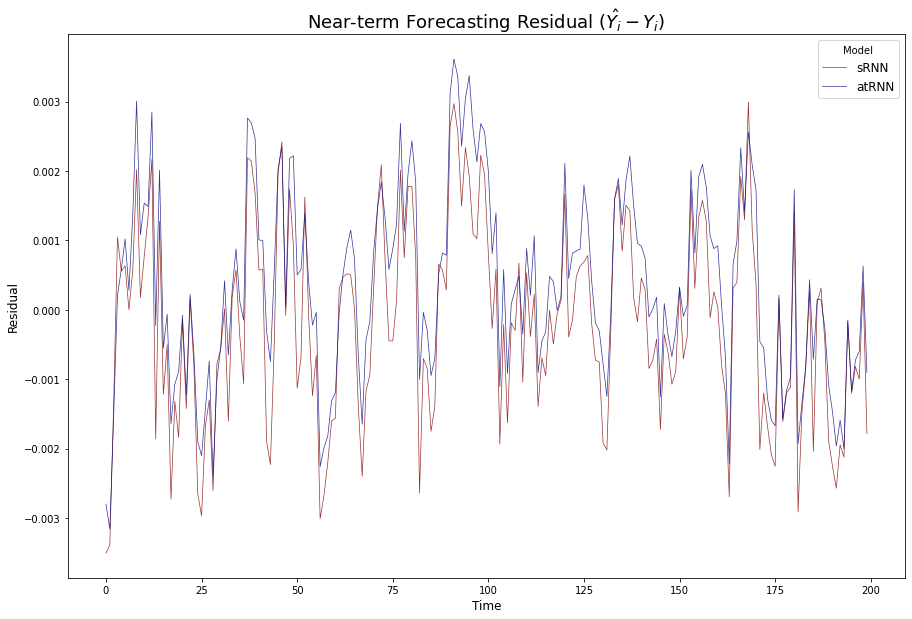

In [ ]:
# Plot near_term forecasting residuals for test set
upper_limit = 200
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, upper_limit).reshape(upper_limit, 1)
colors = pl.cm.jet(np.linspace(1, 0, 2))
i = 0

for k in params.keys():
    residual = params[k]['predict'][:upper_limit] - y_test_reg[:upper_limit].reshape(upper_limit, 1)
    plt.plot(_x, residual, color = colors[i], label = params[k]['label'], alpha = 0.8, linewidth = 0.7)
    i += 1

plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('Near-term Forecasting Residual ($\hat{Y_i} - Y_i$)', fontsize = 18)

Text(0.5, 1.0, 'Trimmed Test Residual ($\\hat{Y_i} - Y_i$)')

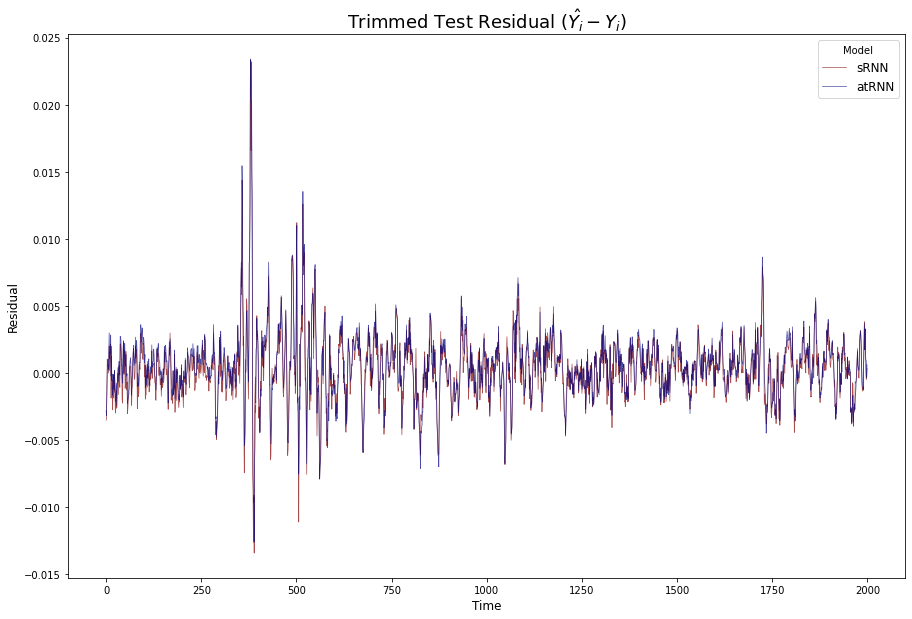

In [ ]:
# Plot trimmed residuals for test set
upper_limit = 2000
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, upper_limit).reshape(upper_limit, 1)
colors = pl.cm.jet(np.linspace(1, 0, 2))
i = 0

for k in params.keys():
    residual = params[k]['predict'][:upper_limit] - y_test_reg[:upper_limit].reshape(upper_limit, 1)
    plt.plot(_x, residual, color = colors[i], label = params[k]['label'], alpha = 0.7, linewidth = 0.7)
    i += 1

plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('Trimmed Test Residual ($\hat{Y_i} - Y_i$)', fontsize = 18)

Text(0.5, 1.0, 'Untrimmed Test Residual ($\\hat{Y_i} - Y_i$)')

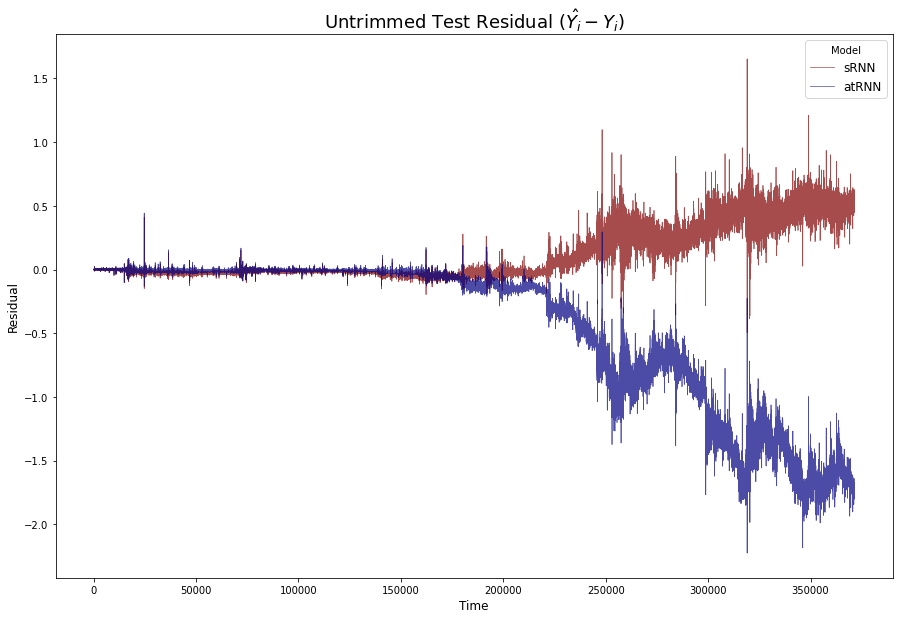

In [ ]:
# Plot untrimmed residuals for test set
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, len(y_test_reg))
colors = pl.cm.jet(np.linspace(1, 0, 2))
i = 0

for k in params.keys():
    residual = params[k]['predict'] - y_test_reg
    plt.plot(_x, residual, color = colors[i], label = params[k]['label'], alpha = 0.7, linewidth = 0.7)
    i += 1

plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('Untrimmed Test Residual ($\hat{Y_i} - Y_i$)', fontsize = 18)

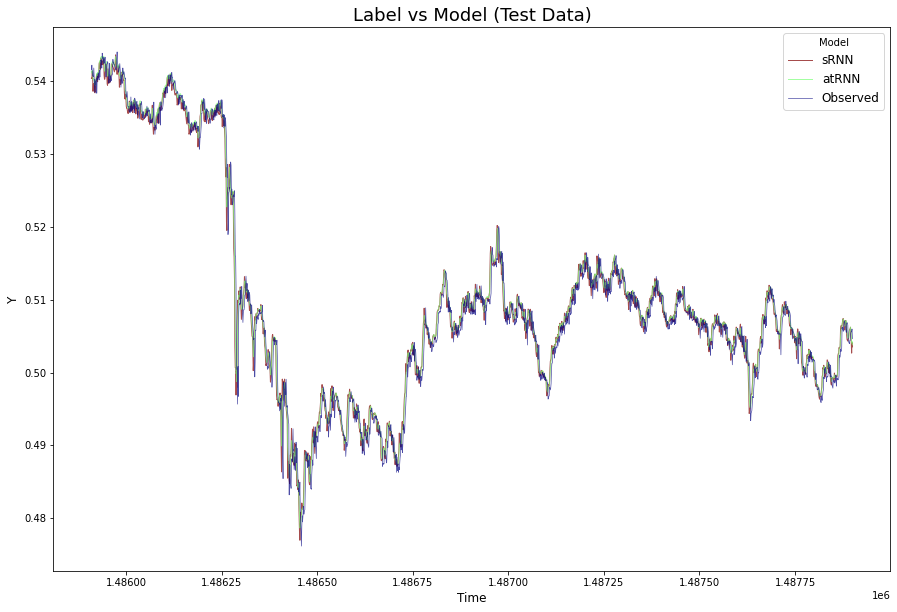

In [ ]:
# Plot prediction vs label performance
fig = plt.figure(figsize = (15, 10))
upper_limit = 2000
colors = pl.cm.jet(np.linspace(1, 0, 3))
i = 0

for k in params.keys():
    plt.plot(test.index[step_lag : upper_limit], params[k]['predict'][step_lag : upper_limit], linewidth = 1.0,
             color = colors[i], label = params[k]['label'], alpha = 0.7)
    i += 1
    
plt.plot(test.index[step_lag : upper_limit], test[features][step_lag : upper_limit], linewidth = 0.7,
         color = colors[i], label = 'Observed', alpha = 0.7)

plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Label vs Model (Test Data)', fontsize = 18)

plt.show()

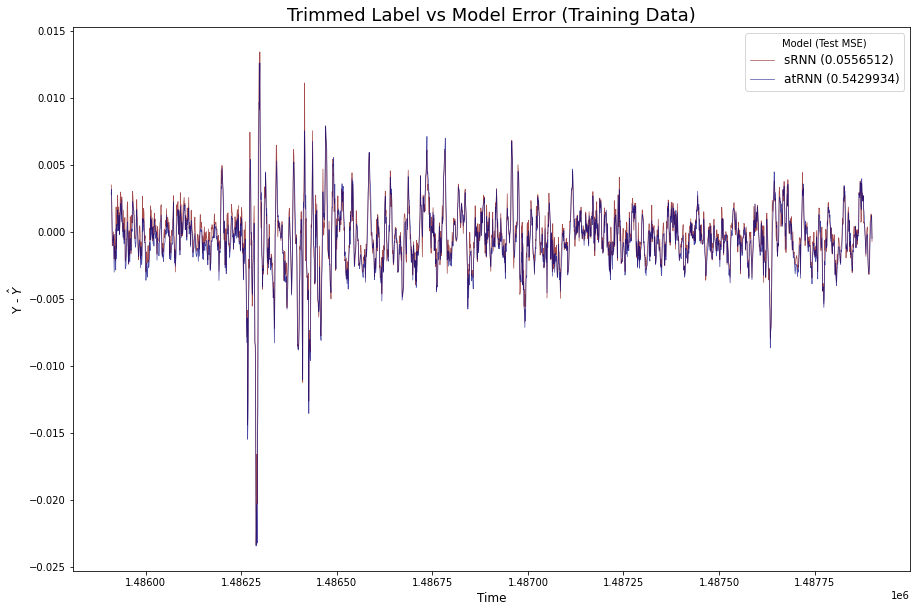

In [ ]:
# Plot prediction vs label error
fig = plt.figure(figsize = (15, 10))
dim = len(test.index[step_lag : upper_limit])
x_plot = test.index[step_lag : upper_limit]
colors = pl.cm.jet(np.linspace(1, 0, 2))
i = 0

for k in params.keys():
    nn_y_plot = test[features][step_lag : upper_limit] - params[k]['predict'][: upper_limit - (step_lag), 0].reshape(dim, 1)
    plt.plot(x_plot, nn_y_plot, color = colors[i], label = params[k]['label'] + " (" + str( round( params[k]['MSE_test'], 7) ) + ")",
             alpha = 0.7, linewidth = 0.7)
    i += 1

plt.legend(loc = 'best', title = 'Model (Test MSE)', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Y - $\hat{Y}$', fontsize = 12)
plt.title('Trimmed Label vs Model Error (Training Data)', fontsize = 18)

plt.show()

In [ ]:
print('Model Errors:')

for k in params.keys():
    print('Model: ' + params[k]['label'])
    print('   Train MSE = ' + str(params[k]['MSE_train']))
    print('   Test MSE = ' + str(params[k]['MSE_test']))
    print()

Model Errors:
Model: sRNN
   Train MSE = 0.0009290071106337042
   Test MSE = 0.05565122767345141

Model: atRNN
   Train MSE = 0.0014931282946763164
   Test MSE = 0.5429933681754268

